In [7]:
import numpy as np
import torch
from torch import Tensor
from scipy.linalg import toeplitz
import scipy.sparse

from typing import Tuple, List, Optional

import matplotlib.pyplot as plt
import seaborn as sns

from stable_baselines3.common.buffers import RolloutBuffer

sns.set()

from tqdm import trange, tqdm

In [120]:
import numba

In [8]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [9]:
def exp_discount_episode(rewards: np.ndarray,
                         values: np.ndarray,
                         γ: float = 0.99) -> Tuple[np.ndarray, np.ndarray]:
    
    discount_vector = np.array([[γ**t for t in range(len(rewards))]])
    
    discount_mat = np.triu(toeplitz(discount_vector))
    
    returns = discount_mat @ rewards
    
    advantages = returns - values
    
    return returns, advantages

In [10]:
def exp_kernel_discount(rewards: np.ndarray,  # Clearly a superior implementation
                        values: np.ndarray,
                        γ: float = 0.99) -> Tuple[np.ndarray, np.ndarray]:

    T = len(rewards)
    discount_vector = np.array([[γ**t for t in range(len(rewards))]])
    returns = np.zeros_like(rewards)
    
    for i in range(T):
        returns[i] = discount_vector[:,:T-i] @ rewards[i:]
        
    advantages = returns - values
        
    return returns, advantages


In [11]:
def exp_slower_discount(rewards: np.ndarray,  # Clearly an inferior implementation
                        values: np.ndarray,
                        γ: float = 0.99) -> Tuple[np.ndarray, np.ndarray]:
    
    returns = np.zeros_like(rewards)
    T = len(rewards)
    
    for i in range(T):
        discount_vector = np.array([[γ**t for t in range(T-i)]])

        returns[i] = discount_vector @ rewards[i:]
        
    advantages = returns - values
        
    return returns, advantages


In [12]:
def get_beta_vector(T: int,
                    α: float,
                    β: float) -> np.ndarray:
    
    discount = np.zeros((1, T))
    
    current_discount = 1
    for t in range(T):
        discount[0, t] = current_discount
        current_discount *= (α + t) / (α + β + t)
        
    return discount

def beta_kernel_discount(rewards: np.ndarray,
                         values: np.ndarray,
                         α: float = 99*100,
                         β: float = 1*100):
    T = len(rewards)
    discount_vector = get_beta_vector(T, α, β)
    returns = np.zeros_like(rewards)
    
    for i in range(T):
        returns[i] = discount_vector[:,:T-i] @ rewards[i:]
#         discount_vector = discount_vector[:, :-1]
        
    advantages = returns - values
    
    return returns, advantages


In [13]:
def alt_gae(rewards: np.ndarray,
            values: np.ndarray, 
            last_values: np.ndarray,
            γ: float = 0.99,
            λ: float = 0.95):
    
    T = len(rewards)
    advantages = np.zeros((T, 1))

    next_values = np.concatenate((values, last_values))[1:]
    
    deltas = rewards + γ * next_values - values
    
    decay_vector = np.array([[(γ * λ)**l for l in range(T)]])
    
    for t in range(T):
        advantages[t] = decay_vector[:,:T-t] @ deltas[t:]
        
    returns = advantages + values
    
    return returns, advantages

In [16]:
def gae(rewards: np.ndarray,
        values: np.ndarray,
        last_values: np.ndarray,
        dones: np.ndarray,
        final_dones: np.ndarray,
        γ: float = 0.99,
        λ: float = 0.95) -> Tuple[np.ndarray, np.ndarray]:
    
    returns = np.zeros_like(rewards)
    advantages = np.zeros_like(rewards)
    
    buffer_size = rewards.shape[0]

    last_gae_lam = 0
    for step in reversed(range(buffer_size)):
        if step == buffer_size - 1:
            next_non_terminal = 1.0 - final_dones
            next_values = last_values
        else:
            next_non_terminal = 1.0 - dones[step + 1]
            next_values = values[step + 1]
                        
        delta = rewards[step] + γ * next_values * next_non_terminal - values[step]
        
        last_gae_lam = delta + γ * λ * next_non_terminal * last_gae_lam
        
        advantages[step] = last_gae_lam
        
    returns = advantages + values
    
    return returns, advantages

In [17]:
class RolloutBuffer:

    def __init__(
        self,
        buffer_size: int,
        gae_lambda: float = 1,
        gamma: float = 0.99,
        n_envs: int = 1,
    ):

        self.buffer_size = buffer_size
        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.n_envs = n_envs
        self.reset()

    def reset(self) -> None:
        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.dones = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)

    def compute_returns_and_advantage(self, last_values: np.ndarray, dones: np.ndarray) -> None:
        """
        Post-processing step: compute the returns (sum of discounted rewards)
        and GAE advantage.
        Adapted from Stable-Baselines PPO2.

        Uses Generalized Advantage Estimation (https://arxiv.org/abs/1506.02438)
        to compute the advantage. To obtain vanilla advantage (A(s) = R - V(S))
        where R is the discounted reward with value bootstrap,
        set ``gae_lambda=1.0`` during initialization.

        :param last_values:
        :param dones:

        """
        # convert to numpy
#         last_values = last_values.clone().cpu().numpy().flatten()

        last_gae_lam = 0
        for step in reversed(range(self.buffer_size)):
            if step == self.buffer_size - 1:
                next_non_terminal = 1.0 - dones
                next_values = last_values
            else:
                next_non_terminal = 1.0 - self.dones[step + 1]
                next_values = self.values[step + 1]
            delta = self.rewards[step] + self.gamma * next_values * next_non_terminal - self.values[step]
            last_gae_lam = delta + self.gamma * self.gae_lambda * next_non_terminal * last_gae_lam
            self.advantages[step] = last_gae_lam
        self.returns = self.advantages + self.values

In [92]:
from numba import njit

In [157]:
import numpy as np
from numba import njit

@njit
def get_beta_vector(T: int,
                    α: float,
                    β: float) -> np.ndarray:
    discount = np.zeros((1, T), dtype=np.float32)

    current_discount = 1
    for t in range(T):
        discount[0, t] = current_discount
        current_discount *= (α + t) / (α + β + t)

    return discount

@njit
def beta_gae(rewards: np.ndarray,  # [T, N]
             values: np.ndarray,  # [T, N]
             last_values: np.ndarray,  # [1, N]
             dones: np.ndarray,  # [T, N], actually next_dones (whether previous step was terminal)
             final_dones: np.ndarray,  # [1, ]
             α: float = 99.,
             β: float = 1.,
             λ: float = 0.95):
    T = rewards.shape[0]
    N = rewards.shape[1]  # Number of envs
    
    advantages = np.zeros((T, N), dtype=np.float32)

    final_dones = final_dones.reshape((1, N))
    last_values = last_values.reshape((1, N))
    next_non_terminal = 1 - np.concatenate((dones, final_dones))[1:]
    next_values = np.concatenate((values, last_values))[1:]

    Γ = get_beta_vector(T + 1, α, β)
    lambdas = np.array([[λ ** l for l in range(T)]], dtype=np.float32)

    #     γ = α / (α + β)
    #     Γ = np.array([[γ**l for l in range(T+1)]])


    for n in range(N):
        # Done preprocessing step
        steps_until_eoe = np.zeros((T,), dtype=np.int32)
        is_final = np.zeros((T,), dtype=np.int32)
        counter = 0
        final = 1
        done = False
        factor = None
        
        for i, d in list(enumerate(dones[:, n]))[::-1]:
            if done:
                counter = 0
                done = False
                final = 0
            steps_until_eoe[i] = counter
            is_final[i] = final
            counter += 1
            done = d

        for i in range(T):
            steps_left = steps_until_eoe[i]

            old_value = -values[i, n]
            future_rewards = (lambdas[:, :steps_left + 1] * Γ[:, :steps_left + 1]) @ rewards[i:i + steps_left + 1,n:n+1]

            if is_final[i]:
                steps_left += 1

                # Fix to properly handle the very last value of an episode
                if factor is None:
                    factor = np.array([[1 - λ for i in range(steps_left)]], dtype=np.float32).T
                    factor[-1] = 1.
                else:
                    factor = factor[1:]

                future_values = (lambdas[:, :steps_left] * Γ[:, 1:steps_left + 1]) @ (
                            next_values[i:i + steps_left, n:n+1] * next_non_terminal[i:i + steps_left, n:n+1] * factor[-steps_left:])

            else:
                future_values = np.float32(1. - λ) * (lambdas[:, :steps_left] * Γ[:, 1:steps_left + 1]) @ (
                            next_values[i:i + steps_left, n:n+1] * next_non_terminal[i:i + steps_left, n:n+1])
            
            total = old_value + future_rewards + future_values
            advantages[i, n] = total[0,0]

    returns = advantages + values

    return returns, advantages




In [183]:
foo = np.array([0,0,0], dtype=np.float32)

# Simpler test

In [158]:
T = 2

rewards = np.array([[0. for t in range(T)]]).T.astype(np.float32)
values = (np.zeros_like(rewards) + 0.5).astype(np.float32)
dones = np.zeros_like(rewards).astype(np.float32)
final_dones = np.array([[0.]]).astype(np.float32)
last_values = np.array([[0.5]]).astype(np.float32)

# dones = np.zeros((T, 1))
# for i in range(0,T,T//10):
#     dones[i, 0] = 1 if i > 0 else 0

In [159]:
buffer = RolloutBuffer(T, 0.95, 0.9, 1)

buffer.rewards = rewards
buffer.values = values
buffer.dones = dones


buffer.compute_returns_and_advantage(last_values, final_dones)

<ipython-input-157-f9b10662c7b7>:63: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  future_rewards = (lambdas[:, :steps_left + 1] * Γ[:, :steps_left + 1]) @ rewards[i:i + steps_left + 1,n:n+1]
/Users/redtachyon/anaconda3/envs/beta/lib/python3.8/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


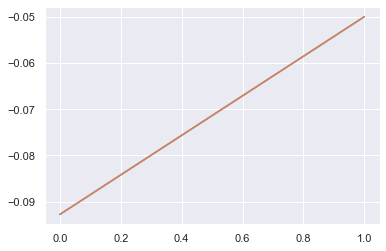

In [160]:
beta_ret, beta_adv = beta_gae(rewards, values, last_values, dones, final_dones, 9.*1e10, 1.*1e10, np.float32(0.95))

plt.plot(buffer.advantages)

plt.plot(beta_adv)

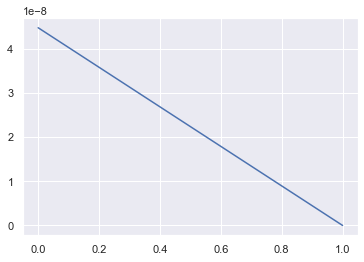

In [161]:
plt.plot(beta_adv - buffer.advantages)

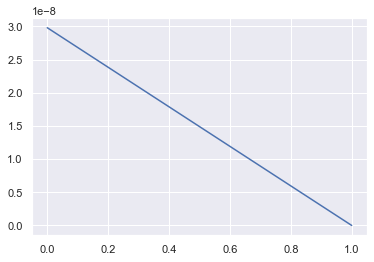

In [162]:
diff = beta_ret - buffer.returns
plt.plot(diff)

# Simple test

In [168]:
T = 100

rewards = np.array([[1. if t >= T//2 else 0. for t in range(T)]]).T.astype(np.float32)
values = (np.zeros_like(rewards) + 0.5).astype(np.float32)
dones = np.zeros_like(rewards).astype(np.float32)
final_dones = np.array([[1.]]).astype(np.float32)
last_values = np.array([[1.]]).astype(np.float32)

dones = np.zeros((T, 1)).astype(np.float32)
for i in range(0,T,T//10):
    dones[i, 0] = 1 if i > 0 else 0

In [169]:
buffer = RolloutBuffer(T, 0.95, 0.9, 1)

buffer.rewards = rewards
buffer.values = values
buffer.dones = dones


buffer.compute_returns_and_advantage(last_values, final_dones)

<ipython-input-157-f9b10662c7b7>:63: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  future_rewards = (lambdas[:, :steps_left + 1] * Γ[:, :steps_left + 1]) @ rewards[i:i + steps_left + 1,n:n+1]
/Users/redtachyon/anaconda3/envs/beta/lib/python3.8/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


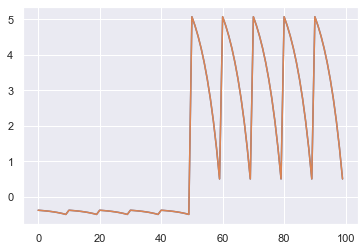

In [170]:
beta_ret, beta_adv = beta_gae(rewards, values, last_values, dones, final_dones, 9.*1e10, 1.*1e10, 0.95)

plt.plot(buffer.advantages)

plt.plot(beta_adv)

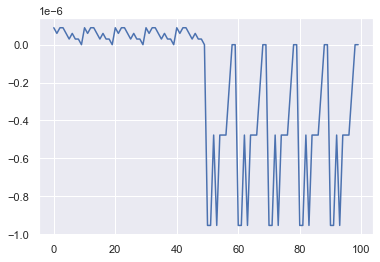

In [171]:
plt.plot(beta_adv - buffer.advantages)

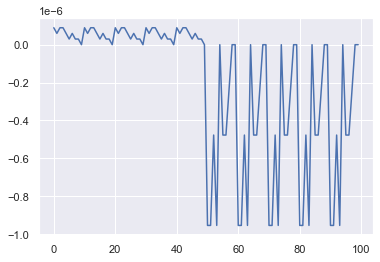

In [172]:
diff = beta_ret - buffer.returns
plt.plot(diff)

# Random test

In [175]:
T = 10000

rewards = np.random.rand(T, 1).astype(np.float32)
values = np.random.rand(T, 1).astype(np.float32)
dones = np.zeros_like(rewards).astype(np.float32)
final_dones = np.array([[1]]).astype(np.float32)
last_values = np.array([[0.]]).astype(np.float32)

dones = np.zeros((T, 1)).astype(np.float32)
for i in range(0,T,T//10):
    dones[i, 0] = 1 if i > 0 else 0

In [176]:
buffer = RolloutBuffer(T, 0.95, 0.9, 1)

buffer.rewards = rewards
buffer.values = values
buffer.dones = dones


buffer.compute_returns_and_advantage(last_values, final_dones)

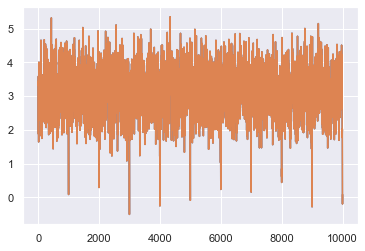

In [177]:
beta_ret, beta_adv = beta_gae(rewards, values, last_values, dones, final_dones, 1e10*9., 1e10*1., 0.95)

plt.plot(buffer.advantages)

plt.plot(beta_adv)

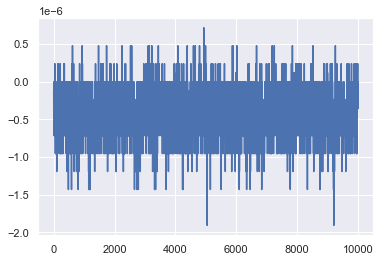

In [178]:
plt.plot(beta_adv - buffer.advantages)

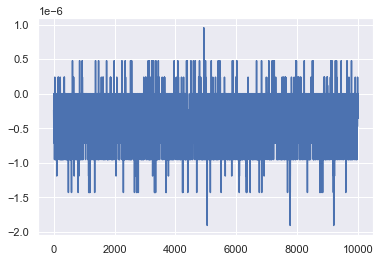

In [179]:
diff = beta_ret - buffer.returns
plt.plot(diff)

In [191]:
T = 10000

rewards = np.random.rand(T, 1).astype(np.float32)
values = np.random.rand(T, 1).astype(np.float32)
dones = np.zeros_like(rewards).astype(np.float32)
final_dones = np.array([[0]]).astype(np.float32)
last_values = np.array([[0.5]]).astype(np.float32)

dones = np.zeros((T, 1)).astype(np.float32)
for i in range(0,T,T//10):
    dones[i, 0] = 1 if i > 0 else 0

In [192]:
N = 10

m_rewards = np.concatenate([rewards] * N, 1)
m_values = np.concatenate([values] * N, 1)
m_last_values = np.concatenate([last_values] * N, 1)
m_dones = np.concatenate([dones] * N, 1)
m_final_dones = np.concatenate([final_dones] * N, 1)

In [193]:
%%timeit
beta_gae(m_rewards, m_values, m_last_values, m_dones, m_final_dones, 99., 1., 0.95)

419 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [194]:
%%timeit

buffer = RolloutBuffer(T, 0.95, 0.9, N)

buffer.rewards = m_rewards
buffer.values = m_values
buffer.dones = m_dones


buffer.compute_returns_and_advantage(last_values, final_dones)

67.5 ms ± 791 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
beta_gae(m_rewards, m_values, m_last_values, m_dones, m_final_dones, 99., 1., 0.95)

In [311]:
m_dones.shape

(1000, 10)

# KINDA WORKING VERSION

In [343]:
def get_beta_vector(T: int,
                    α: float,
                    β: float) -> np.ndarray:
    
    discount = np.zeros((1, T))
    
    current_discount = 1
    for t in range(T):
        discount[0, t] = current_discount
        current_discount *= (α + t) / (α + β + t)
        
    return discount

def beta_gae(rewards: np.ndarray,      # [T, N]
             values: np.ndarray,       # [T, N]
             last_values: np.ndarray,  # [1, N]
             dones: np.ndarray,        # [T, N], actually next_dones (whether previous step was terminal)
             final_dones: np.ndarray,  # [1, N]
             α: float = 99.,
             β: float = 1.,
             λ: float = 0.95):
    
    T = rewards.shape[0]
    N = rewards.shape[1]  # Number of envs
    
    advantages = np.zeros((T, N))
    
    next_non_terminal = 1-np.concatenate((dones, final_dones))[1:]
    next_values = np.concatenate((values, last_values))[1:]

    
    # Process dones
    # !!! Assume all environments have episode ends simultaneously !!!
    steps_until_eoe = np.zeros((T,), dtype=int)
    is_final = np.zeros((T,), dtype=int)  # Might be starting too early OOBE
    counter = 0
    final = 1
    done = False
    for i, d in reversed(list(enumerate(dones[:, 0]))):
        if done:
            counter = 0
            done = False
            final = 0
        steps_until_eoe[i] = counter
        is_final[i] = final
        counter += 1
        done = d
        
    
    Γ = get_beta_vector(T+1, α, β)
    lambdas = np.array([[λ**l for l in range(T)]])
    
#     γ = α / (α + β)
#     Γ = np.array([[γ**l for l in range(T+1)]])

    factor = None
    
    for i in range(T):
        steps_left = steps_until_eoe[i]
        ep_lambdas = lambdas[:,:steps_left]
        

        old_value = -values[i]
        future_rewards = (lambdas[:,:steps_left+1] * Γ[:,:steps_left+1]) @ rewards[i:i+steps_left+1]
        
        if is_final[i]:
            steps_left += 1
            
            # Fix to properly handle the very last value of an episode
            if factor is None:
                factor = np.array([[1-λ for i in range(steps_left)]]).T
                factor[-1] = 1.
            else:
                factor = factor[1:]
                        
            future_values = (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left] * factor[-steps_left:])

        else:
            future_values = (1-λ) * (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left])
        

        advantages[i] = old_value + future_rewards + future_values
        
    returns = advantages + values
    
    return returns, advantages
    
    
